In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Feb 18 07:14:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [109]:
import numpy as np
import pandas as pd
import os, pickle, tqdm, time, random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model, save_model, load_model
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Layer, TimeDistributed, Concatenate, BatchNormalization, RepeatVector, GRU
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.models import Model
from keras.layers.merge import add
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
!unzip '/content/drive/MyDrive/Colab Datasets/Flickr8k_Dataset.zip'

In [5]:
captions_path = '/content/drive/MyDrive/Colab Datasets/Flickr8k_text/Flickr8k.token.txt'

In [6]:
images_dir = '/content/Flicker8k_Dataset'

In [7]:
file = open(captions_path, 'r')
text = file.read()

In [8]:
captions = text.split('\n')
descriptions = {}

In [9]:
for caption in captions[:-1]:
    caption = caption.split('\t')
    if len(caption) == 1:
        img, cap = caption[0].split('   ')
    else:
        img, cap = caption
        
    if img[:-2] not in descriptions:
      desc = 'startseq ' + cap + ' endseq'
      descriptions[img[:-2]] = [desc]
    else:
      desc = 'startseq ' + cap + ' endseq'
      descriptions[img[:-2]].append(desc)

In [10]:
for img, caption in descriptions.items():
  for i, cap in enumerate(caption):
    cap.replace("-", " ")
    words = cap.split()
    words = [word.lower() for word in words]
    words = [word for word in words if (word.isalpha())]
    img_caption = ' '.join(words)
    descriptions[img][i] = img_caption

In [11]:
del descriptions['2258277193_586949ec62.jpg.1']

In [12]:
inception_model = InceptionV3(include_top = False, weights = 'imagenet')
inception_model = Model(inputs = inception_model.inputs, outputs = inception_model.layers[-1].output)

87916544/87910968 [==============================] - 1s 0us/step


In [13]:
def load_image(image_path):
  try:
    img = tf.io.read_file(images_dir +'/'+ image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path
  except Exception:
    print('NOT FOUND')

In [17]:
# Get unique images
image_paths = sorted(set(descriptions.keys()))

image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = inception_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(os.path.join('/content/drive/MyDrive/DL & ML Models/Image caption generator model/Image_features_tensor', path_of_feature), bf.numpy())

In [26]:
all_desc = []

for img, desc_list in descriptions.items():
  for des in desc_list:
    all_desc.append(des)

In [27]:
top_k = 5000

tokenize = Tokenizer(num_words = 5000, oov_token = "<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenize.fit_on_texts(all_desc)

In [ ]:
# tokenize.word_index['<pad>'] = 0
# tokenize.index_word[0] = '<pad>'

In [28]:
vocab_size = top_k + 1
vocab_size

5001

In [29]:
for img, desc_list in descriptions.items():
  max_length = max(len(desc.split()) for desc in desc_list)

In [30]:
# create sequences of images, input sequences and output words for an image
def create_sequences(descriptions, captions):
    X1 = list()
    # walk through each description for the image
    # print(len(captions))
    for cap in captions:
        # encode the sequence
        seq = tokenize.texts_to_sequences([cap])[0]  
        seq = pad_sequences([seq], maxlen = max_length, padding = 'pre')[0]
        X1.append(seq)
    return np.array(X1)

In [31]:
img_keys = list(descriptions.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    # print(descriptions[imgt])
    # print(imgt)
    X1 = create_sequences(descriptions, descriptions[imgt])
    capt_len = len(descriptions[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(X1)

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    X1 = create_sequences(descriptions, descriptions[imgv])
    capv_len = len(descriptions[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(X1)

In [32]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [33]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load('/content/drive/MyDrive/DL & ML Models/Image caption generator model/Image_features_tensor/' + img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [44]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size = tf.data.AUTOTUNE)

In [35]:
class BhadanauAtention(tf.keras.Model):
  def __init__(self, units):
    super(BhadanauAtention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [36]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fullyConnected = tf.keras.layers.Dense(embedding_dim)

  def call(self, img_features):
    img_features = self.fullyConnected(img_features)
    img_features = tf.nn.relu(img_features)
    return img_features

In [37]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, max_length):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = Embedding(vocab_size, embedding_dim, mask_zero = True)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences = True, return_state = True, recurrent_initializer = 'glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = BhadanauAtention(self.units)

  def call(self, cap, features, hidden):

    # hidden = tf.zeros((32, self.units))

    # features = encoder(img_tensor)
    context_vector, attention_weights = self.attention(features, hidden)

    cap = self.embedding(cap)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    cap = tf.concat([tf.expand_dims(context_vector, 1), cap], axis = -1)

    output, state = self.gru(cap)

    # shape == (batch_size, max_length, hidden_size)
    cap = self.fc1(output)

    # x shape = (batch_size * max_length, hidden_size)
    cap = tf.reshape(cap, (-1, cap.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    cap = self.fc2(cap)

    return cap, state, attention_weights

  def build_graph(self, img_tensor):
    img_tensor_inp = tf.keras.layers.Input(shape=raw_shape)

    return Model(inputs=[x], outputs=self.call(x))
  
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [38]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size, max_length)

In [95]:
model_encoder = encoder
model_decoder = decoder

In [39]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
metrics_train = tf.keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy')
metrics_val = tf.keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy')

In [40]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [41]:
checkpoint_path = '/content/drive/MyDrive/DL & ML Models/Image caption generator model/Checkpoints'
ckpt = tf.train.Checkpoint(encoder = encoder,
                           decoder = decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [43]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [46]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size = target.shape[0])

  dec_input = tf.expand_dims([tokenize.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

          metrics_train.update_state(target[:, i], predictions)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [50]:
@tf.function
def test_step(img_tensor, target):
  loss_val = 0
  total_loss_val = 0
  
  hidden_val = decoder.reset_state(batch_size = target.shape[0])

  dec_input_val = tf.expand_dims([tokenize.word_index['startseq']] * target.shape[0], 1)

  features_val = encoder(img_tensor)
 
  for i in range(1, target.shape[1]):
    # passing the features through the decoder
    predictions_val, hidden, _ = decoder(dec_input_val, features_val, hidden_val)

    total_loss_val += loss_function(target[:i], predictions_val)
    
    dec_input = tf.expand_dims(target[:, i], 1)

    # Update val metrics
    val_acc_metric.update_state(target[:i], predictions_val)

  return total_loss_val

In [104]:
for epoch in range(start_epoch, 20):
    start = time.time()
    total_loss = 0
    total_loss_val = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss

      if batch % 500 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(
        epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # for (batch_val, (img_tensor_val, target_val)) in enumerate(dataset_val):
    #   batch_loss_val, t_loss_val = test_step(img_tensor_val, target_val)
    #   total_loss_val += t_loss_val

    if epoch % 5 == 0:
      ckpt_manager.save()
      # serialize model to JSON
      # model_json = model_encoder.to_json()
      # with open("/content/drive/MyDrive/DL & ML Models/Image caption generator model/model_encoder.json", "w") as json_file:
      #   json_file.write(model_json)
      #   # serialize weights to HDF5
      #   model_encoder.save_weights("/content/drive/MyDrive/DL & ML Models/Image caption generator model/model_encoder_weights.h5")

      # model_1_json = model_decoder.to_json()
      # with open("/content/drive/MyDrive/DL & ML Models/Image caption generator model/model_encoder.json", "w") as json_file:
      #   json_file.write(model_1_json)
      #   # serialize weights to HDF5
      #   model_decoder.save_weights("/content/drive/MyDrive/DL & ML Models/Image caption generator model/model_decoder_weights.h5")

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    # template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
    # print(template.format(
    #     round((time.time() - t)/60, 2), epoch + 1,
    #     total_loss, float(metrics_train.result()),
    #     total_loss_val, float(metrics_val.result())
    # ))0

Epoch 1 Batch 0 Loss 0.8808
Epoch 1 Batch 500 Loss 0.6777
Epoch 1 Batch 1000 Loss 0.6265
Epoch 1 Batch 1500 Loss 0.6603
Epoch 1 Batch 2000 Loss 0.6910
Epoch 1 Loss 0.627261
Time taken for 1 epoch 160.8191385269165 sec

Epoch 2 Batch 0 Loss 0.6395
Epoch 2 Batch 500 Loss 0.7923
Epoch 2 Batch 1000 Loss 0.5229
Epoch 2 Batch 1500 Loss 0.6150
Epoch 2 Batch 2000 Loss 0.4705
Epoch 2 Loss 0.619093
Time taken for 1 epoch 160.00293064117432 sec

Epoch 3 Batch 0 Loss 0.5407
Epoch 3 Batch 500 Loss 0.5948
Epoch 3 Batch 1000 Loss 0.4585
Epoch 3 Batch 1500 Loss 0.7856
Epoch 3 Batch 2000 Loss 0.5178
Epoch 3 Loss 0.614144
Time taken for 1 epoch 162.72696900367737 sec

Epoch 4 Batch 0 Loss 0.7481
Epoch 4 Batch 500 Loss 0.5716
Epoch 4 Batch 1000 Loss 0.5368
Epoch 4 Batch 1500 Loss 0.5777
Epoch 4 Batch 2000 Loss 0.8170
Epoch 4 Loss 0.605886
Time taken for 1 epoch 161.76999735832214 sec

Epoch 5 Batch 0 Loss 0.6899
Epoch 5 Batch 500 Loss 0.6521
Epoch 5 Batch 1000 Loss 0.6017
Epoch 5 Batch 1500 Loss 0.6948
E

In [118]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenize.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # print(predictions)


        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        # print(predicted_id)
        if not ((tokenize.index_word[predicted_id] == 'endseq') | (tokenize.index_word[predicted_id] == 'startseq') 
        | (tokenize.index_word[predicted_id] == '<unk>')):
          result.append(tokenize.index_word[predicted_id])

        if tokenize.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [119]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenize.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # print(predictions)


        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        # print(predicted_id)
        if not ((tokenize.index_word[predicted_id] == 'endseq') | (tokenize.index_word[predicted_id] == 'startseq') 
        | (tokenize.index_word[predicted_id] == '<unk>')):
          result.append(tokenize.index_word[predicted_id])

        if tokenize.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [120]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

1630
BLEU score : 70.71067811865476
Real Caption: startseq this skateboarder wearing jeans and tennis shoes grabs the board while in the air endseq
Prediction Caption: a boy is skateboarding

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


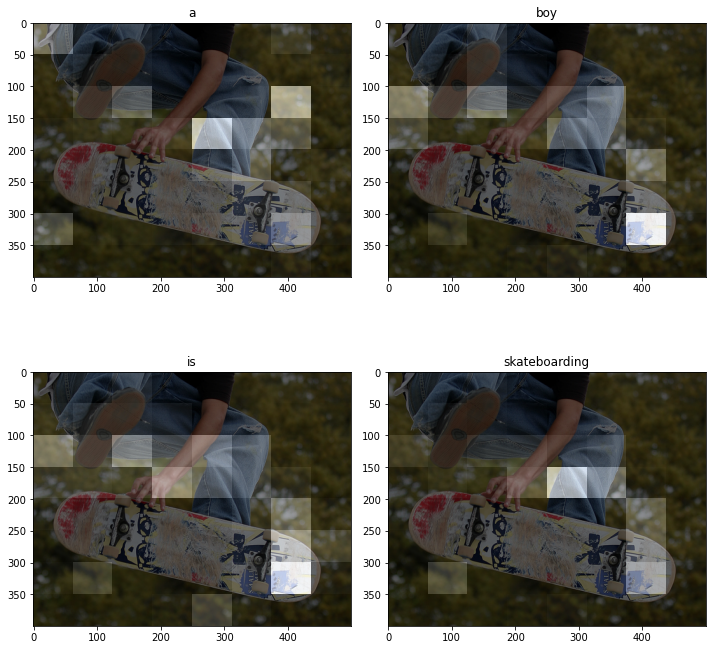

In [121]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
print(rid)
rid = 4754
image = img_name_val[rid]
# print(rid)
real_caption = ' '.join([tokenize.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

score = sentence_bleu(real_caption, result)
print(f"BLEU score : {score * 100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
img_path = images_dir+'/'+image
plot_attention(img_path, result, attention_plot)